In [9]:
import numpy as np
import matplotlib.pyplot as plt

from mytorch.nn.activation import ReLU, Sigmoid, Tanh, LinearActivation
from mytorch.nn.initialization import Xavier, He
from mytorch.nn.linear import Linear
from mytorch.nn.loss import CrossEntropyLoss, L2Loss
from mytorch.optim.optimizer import SGD, Adam
from models.mlp import MLP
import numpyNN

In [10]:
# based on dataset.py from IML HW 6 
def one_hot_encoding(y, num_classes=2):
    one_hot = np.eye(num_classes)[y.astype(int).flatten()]
    return one_hot

In [11]:
def train_and_test_mlp(mlp, x_train, y_train, x_test, y_test, opt_loss, opt_optim, num_epoch=20, batch_size=32):
    assert x_train.shape[0] == y_train.shape[0], "x_train and y_train must have the same length"
    assert x_test.shape[0] == y_test.shape[0], "x_test and y_test must have the same length"

    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []

    y_train_encoded = one_hot_encoding(y_train)  
    y_test_encoded = one_hot_encoding(y_test)

    for epoch in range(num_epoch):
        # Shuffle training data and labels
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train_encoded[indices]

        batch_losses = []
        batch_accuracies = []

        # mini-batches
        for start_idx in range(0, x_train.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, x_train.shape[0])
            batch_x = x_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]

            y_pred_train = mlp.forward(batch_x)
            loss_train = opt_loss.forward(y_pred_train, batch_y)
            batch_losses.append(np.mean(loss_train))

            dLdZ = opt_loss.backward()  # Use correct call for backward computation
            mlp.backward(dLdZ)
            opt_optim.step()
            opt_optim.zero_grad()

            predicted_labels_train = np.argmax(y_pred_train, axis=1)
            true_labels_train = np.argmax(batch_y, axis=1)
            accuracy_train = np.sum(predicted_labels_train == true_labels_train) / len(batch_x)
            batch_accuracies.append(accuracy_train)

        # Compute mean loss and accuracy for the epoch
        epoch_loss = np.mean(batch_losses)
        epoch_accuracy = np.mean(batch_accuracies)
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        # Testing (evaluate the model with the current state on the test set)
        mlp_eval = mlp.copy()  # Ensure your MLP class has a proper copy method
        y_pred_test = mlp_eval.forward(x_test)
        loss_test = opt_loss.forward(y_pred_test, y_test_encoded)
        test_loss.append(np.mean(loss_test))

        predicted_labels_test = np.argmax(y_pred_test, axis=1)
        true_labels_test = np.argmax(y_test_encoded, axis=1)
        accuracy_test = np.sum(predicted_labels_test == true_labels_test) / len(x_test)
        test_accuracy.append(accuracy_test)

        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}, Test Loss: {np.mean(loss_test)}, Test Accuracy: {accuracy_test}")

    logs = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    return logs

In [26]:
def plot_3d (x_train_augmented, feature, savefig=False, name= None):
    # Splitting x_train_augmented into separate features for easier handling
    feature_1 = x_train_augmented[:, 0]
    feature_2 = x_train_augmented[:, 1]
    feature_3 = x_train_augmented[:, 2]

    # Separating data points based on y_train values
    class_0_indices = (y_train.flatten() == 0)
    class_1_indices = (y_train.flatten() == 1)

    # Plotting Feature 1 vs Feature 3
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # (rows, columns, panel number)
    plt.scatter(feature_1[class_0_indices], feature_3[class_0_indices], c='red', label='Class 0')
    plt.scatter(feature_1[class_1_indices], feature_3[class_1_indices], c='blue', label='Class 1')
    plt.title(r'$x_i$ vs $x_{i}^2 + y_i^2$')
    plt.xlabel(r'$x_i$')
    feature = '$' + feature + '$'
    plt.ylabel(rf'{feature}')
    plt.legend()

    # Plotting Feature 2 vs Feature 3
    plt.subplot(1, 2, 2)
    plt.scatter(feature_2[class_0_indices], feature_3[class_0_indices], c='red', label='Class 0')
    plt.scatter(feature_2[class_1_indices], feature_3[class_1_indices], c='blue', label='Class 1')
    plt.title(r'$y_i$ vs $x_{i}^2 + y_i^2$')
    
    plt.xlabel(r'$y_i$')
    plt.ylabel(r'$x_{i}^2 + y_i^2$')
    plt.legend()

    plt.tight_layout()
    if savefig:
        name = name + '-embedding.png'
        plt.savefig(name)
        
    plt.show()

# 7: Non-linear embeddings: Circle

In [37]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'circle',nTrain=200, nTest=200)

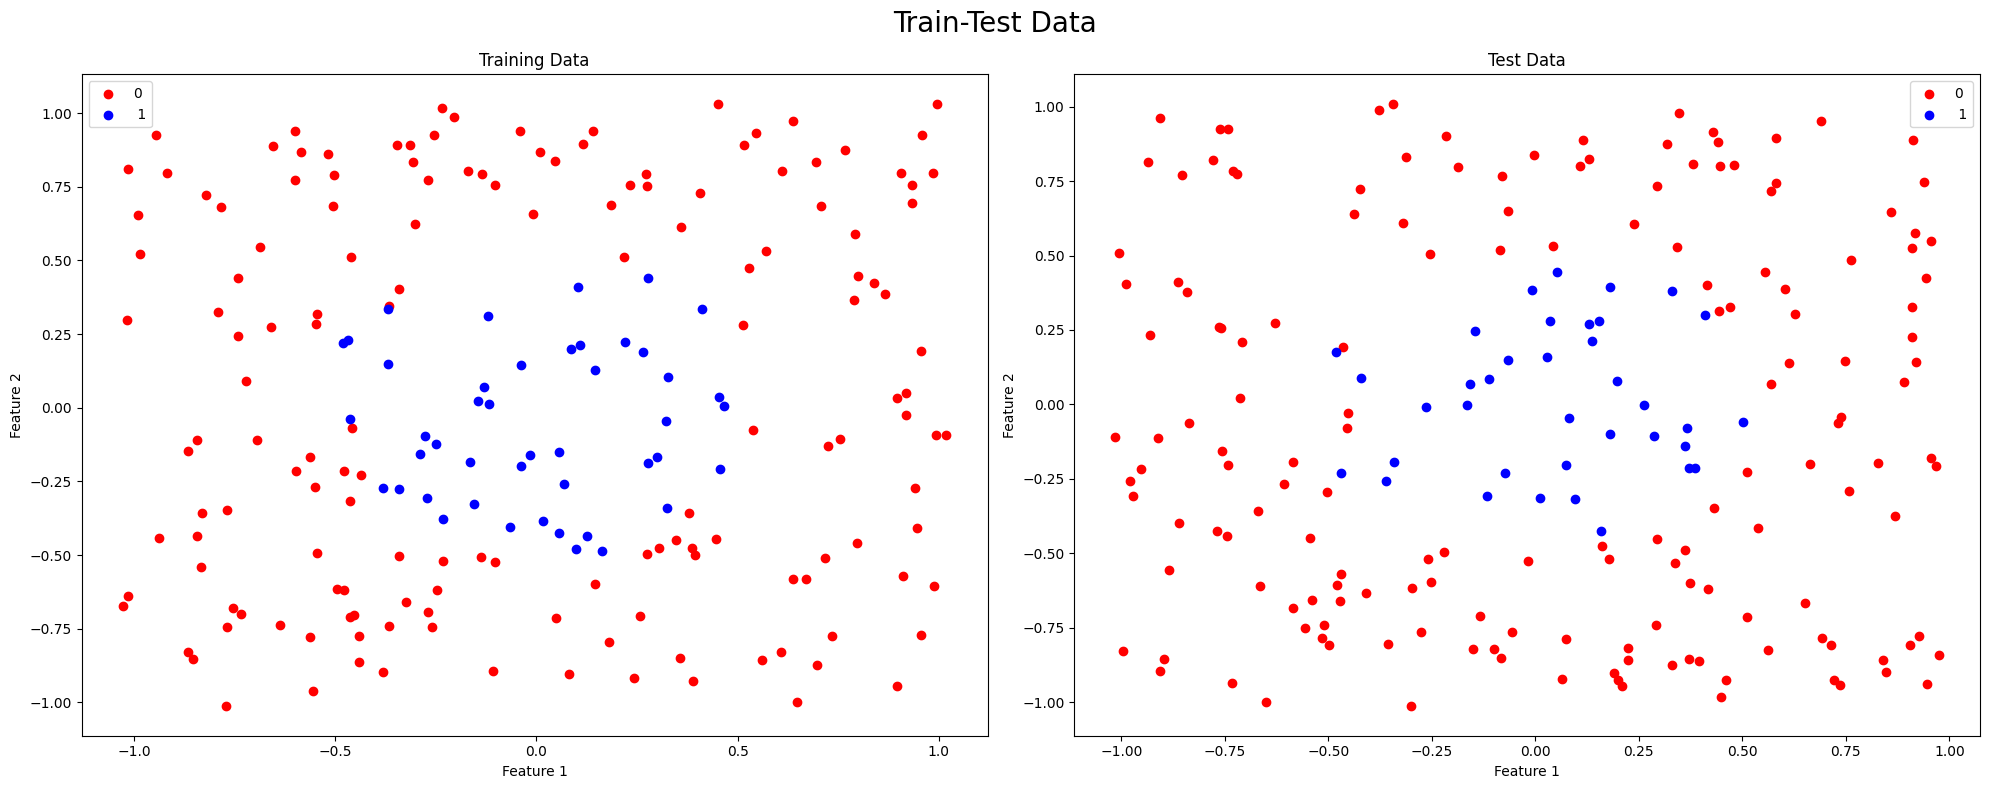

In [38]:
numpyNN.plot_train_test_data(x_train, y_train, x_test, y_test, 'circle-no_embedding')

In [92]:
third_feature_train = np.sum(x_train**2, axis=1)
x_train_augmented = np.concatenate((x_train, third_feature_train[:, np.newaxis]), axis=1)
third_feature_test = np.sum(x_train**2, axis=1)
x_test_augmented = np.concatenate((x_train, third_feature_test[:, np.newaxis]), axis=1)

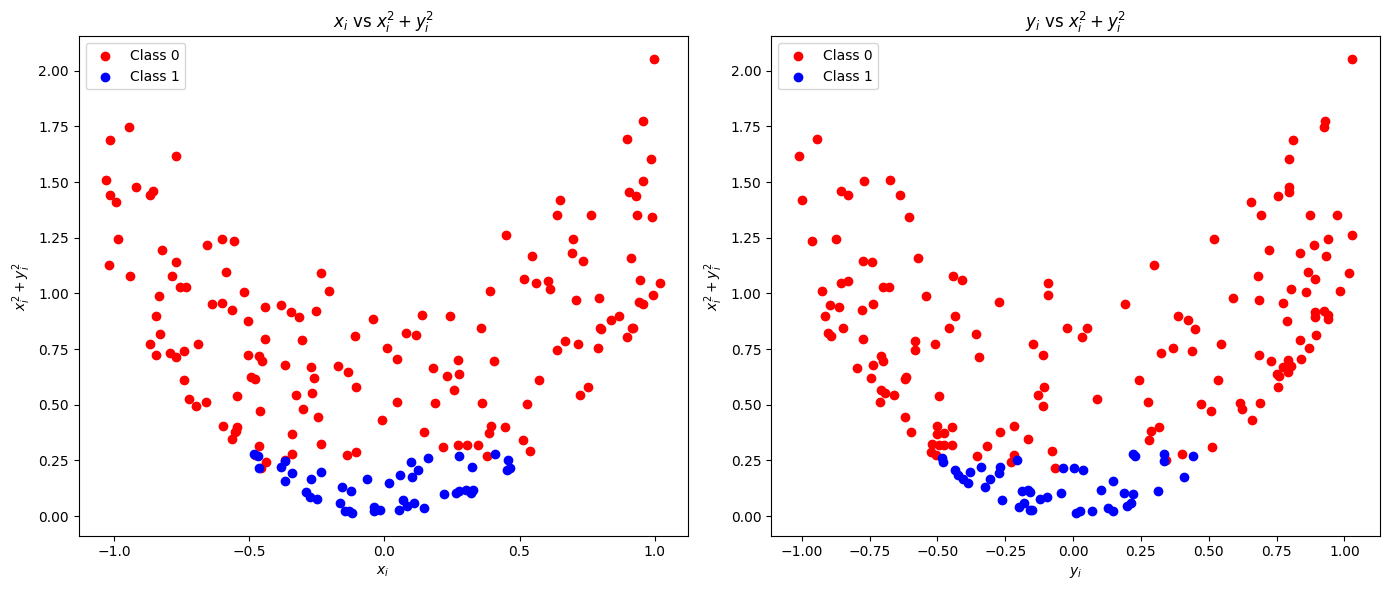

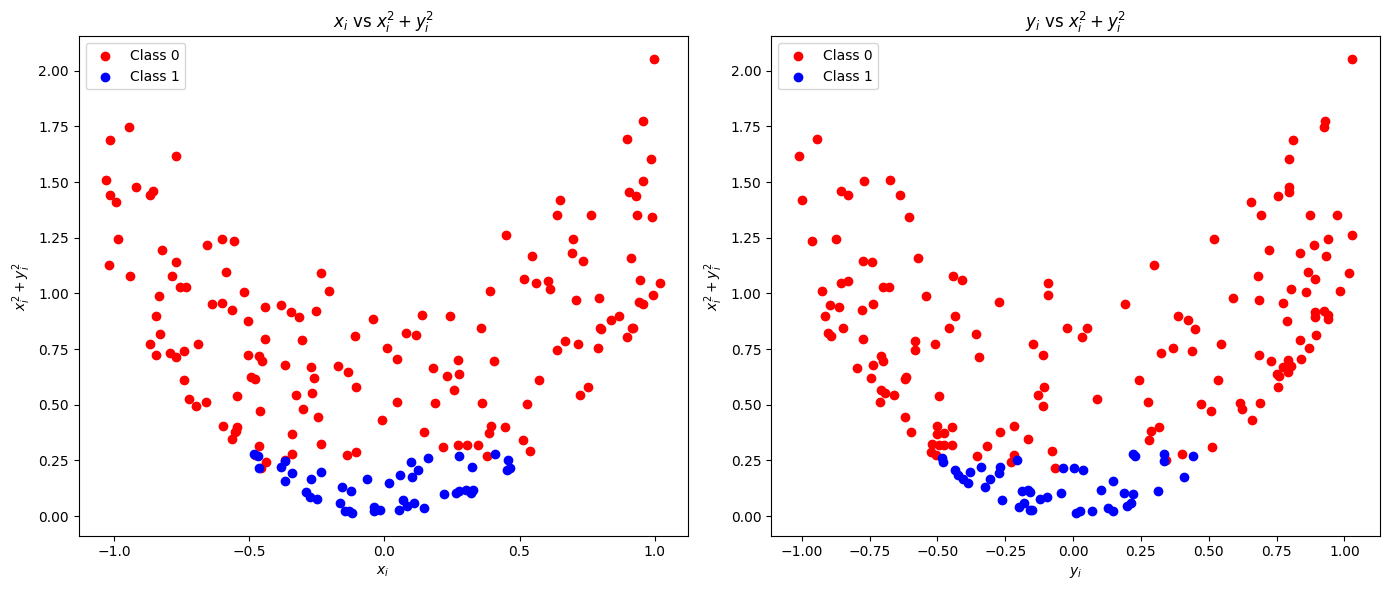

In [127]:
plot_3d(x_train_augmented, 'x_{i}^2 + y_i^2')
plot_3d(x_test_augmented, 'x_{i}^2 + y_i^2')

In [96]:
dim_in, dim_out = 3, 2
hidden_neuron_list = [2,4]
activation_list = ['ReLU', 'Tanh', 'Sigmoid']
opt_init = 'xavier'
opt_loss = CrossEntropyLoss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(mlp)
print(mlp.summary())

Model Summary
-------------
Layer 1: Linear - A Dim: 3, Output Dim: 2, Parameters: 8
Layer 2: ReLU
Layer 3: Linear - A Dim: 2, Output Dim: 4, Parameters: 12
Layer 4: Tanh
Layer 5: Linear - A Dim: 4, Output Dim: 2, Parameters: 10
Layer 6: Sigmoid
Total Parameters: 30
None


In [97]:
circle_embedded_logs = train_and_test_mlp(mlp, x_train_augmented, y_train, x_test_augmented, y_test, opt_loss, opt_optim, num_epoch=150)

Epoch: 0, Train Loss: 0.6974853871355239, Train Accuracy: 0.375, Test Loss: 0.6939425328317431, Test Accuracy: 0.47
Epoch: 1, Train Loss: 0.6952883052634132, Train Accuracy: 0.38839285714285715, Test Loss: 0.6917064558351482, Test Accuracy: 0.515
Epoch: 2, Train Loss: 0.6928486024377823, Train Accuracy: 0.4330357142857143, Test Loss: 0.6894782315609277, Test Accuracy: 0.655
Epoch: 3, Train Loss: 0.6906158713101658, Train Accuracy: 0.6160714285714286, Test Loss: 0.6872293332030683, Test Accuracy: 0.78
Epoch: 4, Train Loss: 0.6875439326807415, Train Accuracy: 0.7455357142857143, Test Loss: 0.684995003129455, Test Accuracy: 0.815
Epoch: 5, Train Loss: 0.6854792768419063, Train Accuracy: 0.7857142857142857, Test Loss: 0.6827445249110418, Test Accuracy: 0.815
Epoch: 6, Train Loss: 0.6843833205395933, Train Accuracy: 0.7723214285714286, Test Loss: 0.6805087669397334, Test Accuracy: 0.815
Epoch: 7, Train Loss: 0.6822547200890234, Train Accuracy: 0.7723214285714286, Test Loss: 0.67830009000162

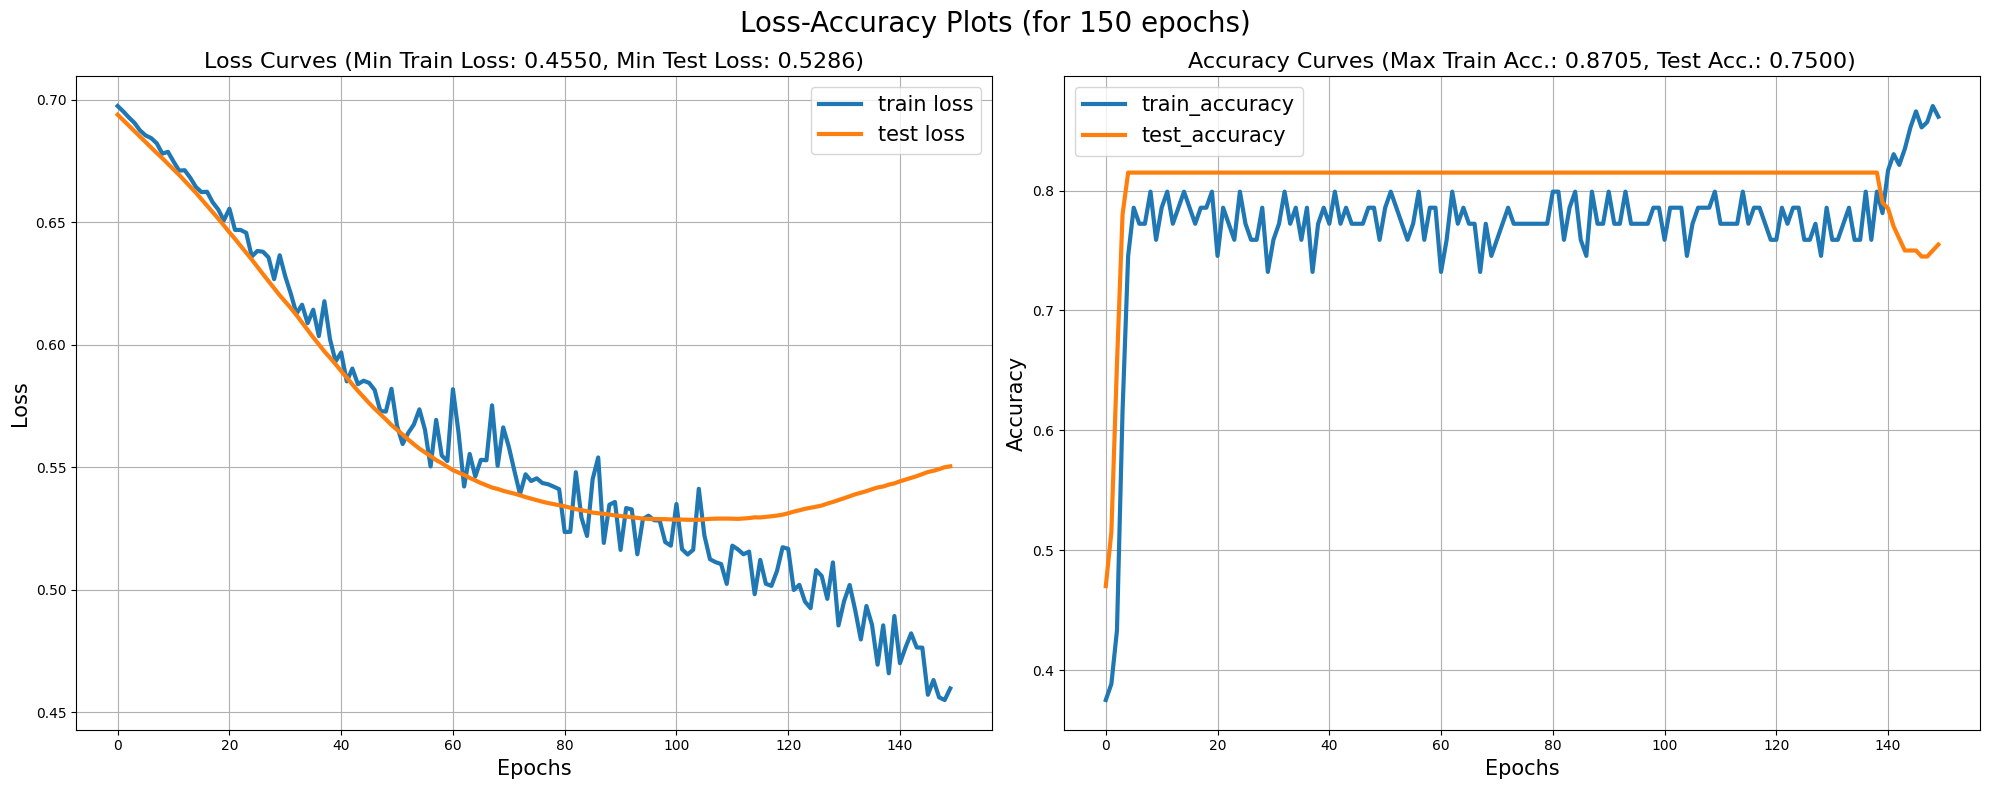

In [98]:
epochs = len(circle_embedded_logs['train_loss'])
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
numpyNN.plot_loss(circle_embedded_logs)
plt.subplot(1, 2, 2)
numpyNN.plot_accuracy(circle_embedded_logs)
plt.suptitle(f'Loss-Accuracy Plots (for {epochs} epochs)', fontsize=20)
plt.tight_layout()

In [99]:
def predict(X, model): # added this to work with my mlp
        y_pred = model.forward(X)
        return np.argmax(y_pred, axis=1)

In [100]:
np.argmax(mlp.forward(x_test_augmented), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0])

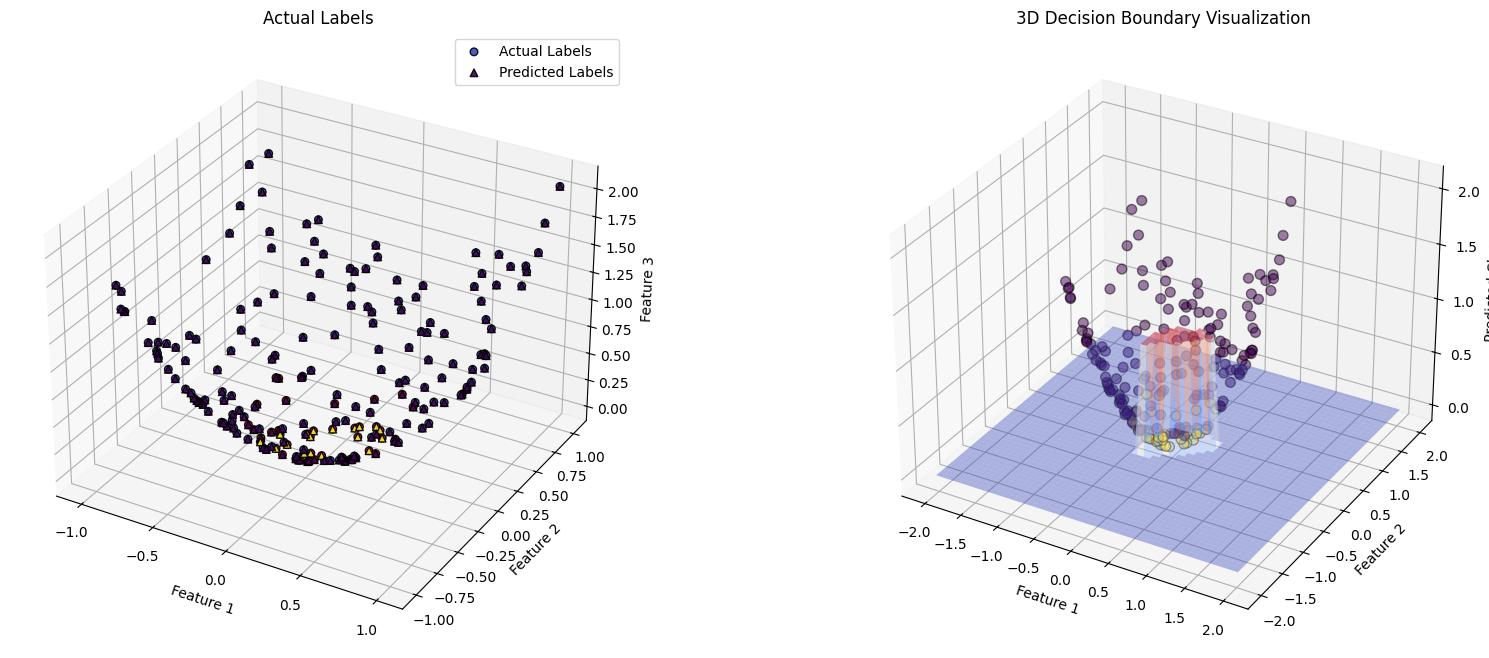

In [152]:

X = x_train_augmented
y = y_train
savefig = False
name = None 

feature_1 = X[:, 0]
feature_2 = X[:, 1]
feature_3 = X[:, 2]

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50),
                        np.linspace(y_min, y_max, num=50))

Z_feature = np.square(xx.ravel()) + np.square(yy.ravel())

X_augmented = np.c_[xx.ravel(), yy.ravel(), Z_feature]

Z_pred =  predict(X_augmented, model=mlp)
Z_pred_reshaped = Z_pred.reshape(xx.shape)
predicted_labels = np.argmax(mlp.forward(X), axis=1)

# Plot for actual labels
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(feature_1, feature_2, feature_3, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o', label='Actual Labels', depthshade=False)
ax1.scatter(feature_1, feature_2, feature_3 , c=predicted_labels, cmap='viridis', edgecolors='k', s=30, alpha=0.9, marker='^', label='Predicted Labels', depthshade=False)

ax1.set_title('Actual Labels')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
ax1.legend()

# Plot for predicted decision boundary using plot_surface
ax2 = fig.add_subplot(122, projection='3d')
surface = ax2.plot_surface(xx, yy, Z_pred_reshaped, cmap='coolwarm', edgecolor='none', alpha=0.4)
ax2.scatter(feature_1, feature_2, feature_3, c=y_train, cmap='viridis', edgecolors='k', s=50, alpha=0.5, marker='o', depthshade=False)
ax2.set_title('Predicted Decision Boundary')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Predicted Class')
    

# fig = plt.figure(figsize=(20, 10))
# ax1 = fig.add_subplot(121, projection='3d')

# # Plotting predicted classes with one marker style
# scatter1 = ax1.scatter(xx.ravel(), yy.ravel(), Z_feature, c=Z_pred, cmap='viridis', depthshade=False, alpha=0.1, marker='^', label='Predicted Labels')

# # Plotting actual data points with another marker style
# ax1.scatter(feature_1, feature_2, feature_3, c=y, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o', label='Actual Labels', depthshade=False)

# ax1.set_xlabel('Feature 1')
# ax1.set_ylabel('Feature 2')
# ax1.set_zlabel('Predicted Class, Decision Boundary')
# ax1.legend()

plt.title('3D Decision Boundary Visualization')

# Adjustments for the second subplot similar to the first, as needed
    # Note: The actual implementation here will depend on the specifics of your dataset and prediction task

if savefig and name:
    plt.savefig(name + 'boundary_3d.png')

plt.show()

In [151]:
# def decisionboundary_3D (X, model, savefig=False, name= None):
#     X = x_test_augmented 
#     feature_1 = x_train_augmented[:, 0]
#     feature_2 = x_train_augmented[:, 1]
#     feature_3 = x_train_augmented[:, 2]
    
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50),
#                             np.linspace(y_min, y_max, num=50))

#     Z_feature = np.square(xx.ravel()) + np.square(yy.ravel())

#     X_augmented = np.c_[xx.ravel(), yy.ravel(), Z_feature]

#     Z_pred = predict(X_augmented, model=model)
    
#         # Now, let's plot using the simulated Z_pred
#     fig = plt.figure(figsize=(20,10))
#     ax1 = fig.add_subplot(121, projection='3d')

#     # Since Z_pred represents class predictions, we plot them in 3D space
#     scatter = ax1.scatter(xx.ravel(), yy.ravel(), Z_feature, c=Z_pred, cmap='coolwarm', depthshade=False, alpha=0.5, label='Predicted Class')

#     ax1.scatter(feature_1, feature_2 , feature_3, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, label='Data Points', depthshade=False)

#     ax1.set_xlabel('Feature 1')
#     ax1.set_ylabel('Feature 2')
#     ax1.set_zlabel('Predicted Class, Decision Boundary')
#     ax1.legend()
#     fig.colorbar(scatter, shrink=0.5, aspect=5)
#     plt.title('Simulated 3D Decision Boundary Visualization')


#     # Now, let's plot using the simulated Z_pred
#     ax2 = fig.add_subplot(122, projection='3d')

#     # Since Z_pred represents class predictions, we plot them in 3D space
#     scatter = ax2.scatter(xx.ravel(), yy.ravel(), Z_pred.reshape(xx.shape), c=Z_pred, cmap='coolwarm', depthshade=False)

#     ax2.scatter(feature_1, feature_2 , feature_3, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.5, label='Data Points',depthshade=True)
#     ax2.set_xlabel('Feature 1')
#     ax2.set_ylabel('Feature 2')
#     ax2.set_zlabel('Predicted Class, Decision Boundary')

#     # fig.colorbar(scatter, shrink=0.5, aspect=5)
#     plt.title('Simulated 3D Decision Boundary Visualization')
#     plt.tight_layout()
#     if savefig:
#         name = name + 'boundary_3d.png'
#         plt.savefig(name)
    
#     plt.show()


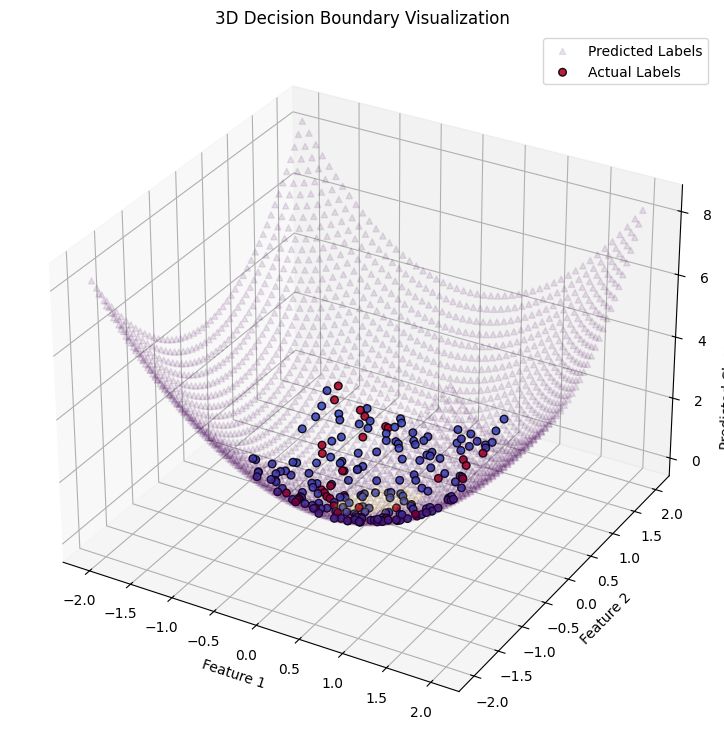

In [126]:
decisionboundary_3D(x_test_augmented, y_test, mlp)

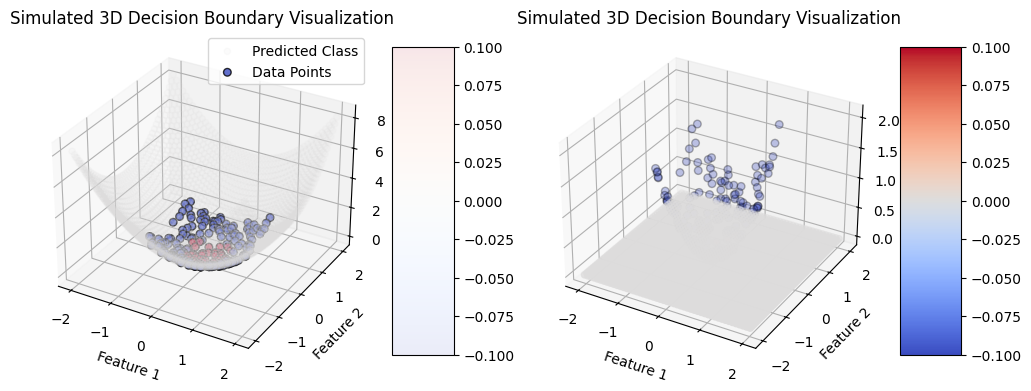

In [57]:
# Now, let's plot using the simulated Z_pred
X = x_test_augmented 
feature_1 = x_train_augmented[:, 0]
feature_2 = x_train_augmented[:, 1]
feature_3 = x_train_augmented[:, 2]
model = mlp
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50),
                        np.linspace(y_min, y_max, num=50))

Z_feature = np.square(xx.ravel()) + np.square(yy.ravel())

X_augmented = np.c_[xx.ravel(), yy.ravel(), Z_feature]

Z_pred = predict(X_augmented, model=model)
    
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')

# Since Z_pred represents class predictions, we plot them in 3D space
scatter = ax1.scatter(xx.ravel(), yy.ravel(), Z_feature, c=Z_pred, cmap='coolwarm', depthshade=True, alpha=0.1, label='Predicted Class')

ax1.scatter(feature_1, feature_2 , feature_3, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.8, label='Data Points', depthshade=True)

ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Predicted Class')
ax1.legend()
fig.colorbar(scatter, shrink=0.5, aspect=5)
plt.title('Simulated 3D Decision Boundary Visualization')


# Now, let's plot using the simulated Z_pred
ax2 = fig.add_subplot(122, projection='3d')

# Since Z_pred represents class predictions, we plot them in 3D space
scatter = ax2.scatter(xx.ravel(), yy.ravel(), Z_pred.reshape(xx.shape), c=Z_pred, cmap='coolwarm', depthshade=True)

ax2.scatter(feature_1, feature_2 , feature_3, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.3, label='Data Points',depthshade=True)
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Predicted Class')

fig.colorbar(scatter, shrink=0.5, aspect=5)
plt.title('Simulated 3D Decision Boundary Visualization')
plt.show()

In [180]:
# def train_and_test_mlp_regression(mlp, x_train, y_train, x_test, y_test, opt_loss, opt_optim, num_epoch=20, batch_size=32):
#     assert x_train.shape[0] == y_train.shape[0], "x_train and y_train must have the same length"
#     assert x_test.shape[0] == y_test.shape[0], "x_test and y_test must have the same length"

#     train_loss = []
#     test_loss = []

  
#     for epoch in range(num_epoch):
#         # Shuffle training data and labels
#         indices = np.arange(x_train.shape[0])
#         np.random.shuffle(indices)
#         x_train_shuffled = x_train[indices]
#         y_train_shuffled = y_train[indices]

#         batch_losses = []

#         # mini-batches
#         for start_idx in range(0, x_train.shape[0], batch_size):
#             end_idx = min(start_idx + batch_size, x_train.shape[0])
#             batch_x = x_train_shuffled[start_idx:end_idx]
#             batch_y = y_train_shuffled[start_idx:end_idx]

#             y_pred_train = mlp.forward(batch_x)
#             loss_train = opt_loss.forward(y_pred_train, batch_y)
#             batch_losses.append(np.mean(loss_train))

#             dLdZ = opt_loss.backward()  # Use correct call for backward computation
#             mlp.backward(dLdZ)
#             opt_optim.step()
#             opt_optim.zero_grad()

#         # Compute mean loss and accuracy for the epoch
#         epoch_loss = np.mean(batch_losses)
#         train_loss.append(epoch_loss)

#         # Testing (evaluate the model with the current state on the test set)
#         mlp_eval = mlp.copy()  # Ensure your MLP class has a proper copy method
#         y_pred_test = mlp_eval.forward(x_test)
#         loss_test = opt_loss.forward(y_pred_test, y_test)
#         test_loss.append(np.mean(loss_test))


#         print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Test Loss: {np.mean(loss_test)}")

#     logs = {
#         "train_loss": train_loss,
#         "test_loss": test_loss,
#     }
#     return logs

In [ ]:
# def train_and_test_scalar(mlp, x_train, y_train, x_test, y_test, opt_loss, opt_optim, num_epoch=20, batch_size=32):
#     assert x_train.shape[0] == y_train.shape[0], "x_train and y_train must have the same length"
#     assert x_test.shape[0] == y_test.shape[0], "x_test and y_test must have the same length"

#     train_loss, train_accuracy = [], []
#     test_loss, test_accuracy = [], []

#     # Assume y_train and y_test are already appropriate for a binary classification task
#     # i.e., they are not one-hot encoded but are binary labels

#     for epoch in range(num_epoch):
#         # Shuffle training data and labels
#         indices = np.arange(x_train.shape[0])
#         np.random.shuffle(indices)
#         x_train_shuffled = x_train[indices]
#         y_train_shuffled = y_train[indices]

#         batch_losses = []
#         batch_accuracies = []

#         # Mini-batches
#         for start_idx in range(0, x_train.shape[0], batch_size):
#             end_idx = min(start_idx + batch_size, x_train.shape[0])
#             batch_x = x_train_shuffled[start_idx:end_idx]
#             batch_y = y_train_shuffled[start_idx:end_idx]

#             y_pred_train = mlp.forward(batch_x).flatten()  # Flatten the output if it's not already 1D
#             loss_train = opt_loss.forward(y_pred_train, batch_y)
#             batch_losses.append(np.mean(loss_train))

#             dLdZ = opt_loss.backward(y_pred_train, batch_y)  # Pass predictions and true values
#             mlp.backward(dLdZ)
#             opt_optim.step()
#             opt_optim.zero_grad()

#             predictions_train = (y_pred_train > 0.5).astype(int)  # Convert probabilities to binary predictions
#             accuracy_train = np.mean(predictions_train == batch_y)
#             batch_accuracies.append(accuracy_train)

#         # Compute mean loss and accuracy for the epoch
#         epoch_loss = np.mean(batch_losses)
#         epoch_accuracy = np.mean(batch_accuracies)
#         train_loss.append(epoch_loss)
#         train_accuracy.append(epoch_accuracy)

#         # Testing (evaluate the model with the current state on the test set)
#         mlp_eval = mlp.copy()  # Ensure your MLP class has a proper copy method
#         y_pred_test = mlp_eval.forward(x_test).flatten()  # Flatten the output if it's not already 1D
#         loss_test = opt_loss.forward(y_pred_test, y_test)
#         test_loss.append(np.mean(loss_test))

#         predictions_test = (y_pred_test > 0.5).astype(int)  # Convert probabilities to binary predictions
#         accuracy_test = np.mean(predictions_test == y_test)
#         test_accuracy.append(accuracy_test)

#         print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}, Test Loss: {np.mean(loss_test)}, Test Accuracy: {accuracy_test}")

#     logs = {
#         "train_loss": train_loss,
#         "train_accuracy": train_accuracy,
#         "test_loss": test_loss,
#         "test_accuracy": test_accuracy
#     }
#     return logs
